In [1]:
import pyedflib
import numpy as np
import pandas as pd
import commands
import pywt
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from pywt import WaveletPacket
import pywt.data
%matplotlib notebook

# Filtros

In [2]:
def filter_signal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = emg_filtered
    #emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

---
# Importando arquivos EDF

In [3]:
file_name = pyedflib.EdfReader('DB_PROTOCOLO/edf/Controle/9/Geraldo Dias de Oliveira - Dia 17.12.11 as 11.21.38.edf')
n = file_name.signals_in_file
signal_labels = file_name.getSignalLabels()
sigbufs = np.zeros((n, file_name.getNSamples()[0]))
for j in np.arange(n):
     sigbufs[j, :] = file_name.readSignal(j)

file_name._close()

df = pd.DataFrame(np.transpose(sigbufs))
df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))

df = df.rename(columns={0: 'Channel 1'})
df = df.rename(columns={1: 'Channel 2'})
df = df.rename(columns={2: 'Channel 3'})
df = df.rename(columns={3: 'Channel 4'})

In [4]:
df.head()

,Time,Channel 1,Channel 2,Channel 3
0,0.0000,-0.634177,6.217391,3.326718
1,0.0005,14.856329,7.625000,1.917557
2,0.0010,9.223418,6.217391,0.508397
3,0.0015,9.223418,4.809783,16.009160
4,0.0020,-6.267089,1.994565,-3.719084


## Tremor de Repouso

<IPython.core.display.Javascript object>


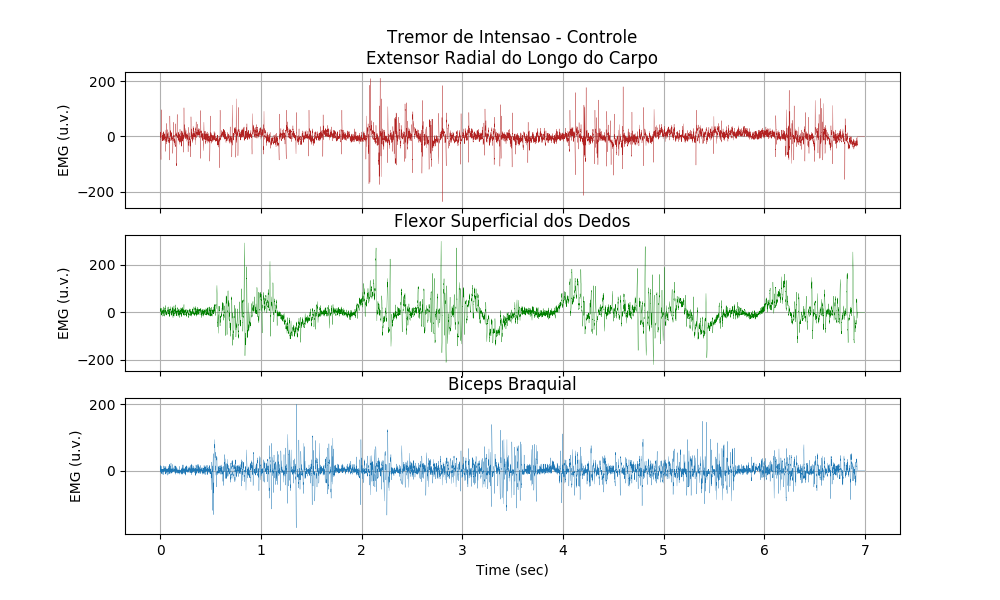

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(df['Time'],df['Channel 1'], linewidth=0.2, color = '#B22222')
ax1.set_title('Tremor de Intensao - Controle'+'\nExtensor Radial do Longo do Carpo')
ax1.set_ylabel('EMG (u.v.)')
ax1.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax2.plot(df['Time'],df['Channel 2'], linewidth=0.2, color = '#008000')
ax2.set_title('\nFlexor Superficial dos Dedos')
ax2.set_ylabel('EMG (u.v.)')
ax2.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax3.plot(df['Time'],df['Channel 3'], linewidth=0.2)
ax3.set_title('\nBiceps Braquial')
ax3.set_ylabel('EMG (u.v.)')
ax3.set_xlabel('Time (sec)')
ax3.grid()
plt.rc('grid', linestyle="dotted", color='black')

plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.set_size_inches(w=10,h=6)

In [6]:
wavelet =pywt.Wavelet('db1')
print (wavelet)

Wavelet db1
  Family name:    Daubechies
  Short name:     db
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [7]:
cA, cD = pywt.dwt(df['Channel 1'], 'db1')

In [8]:
cA

array([ 10.05658005,  13.04388243,   7.06927767, ...,  -0.89686202,
        -0.89686202,  -0.89686202])

## Coefficients Distribution

<IPython.core.display.Javascript object>


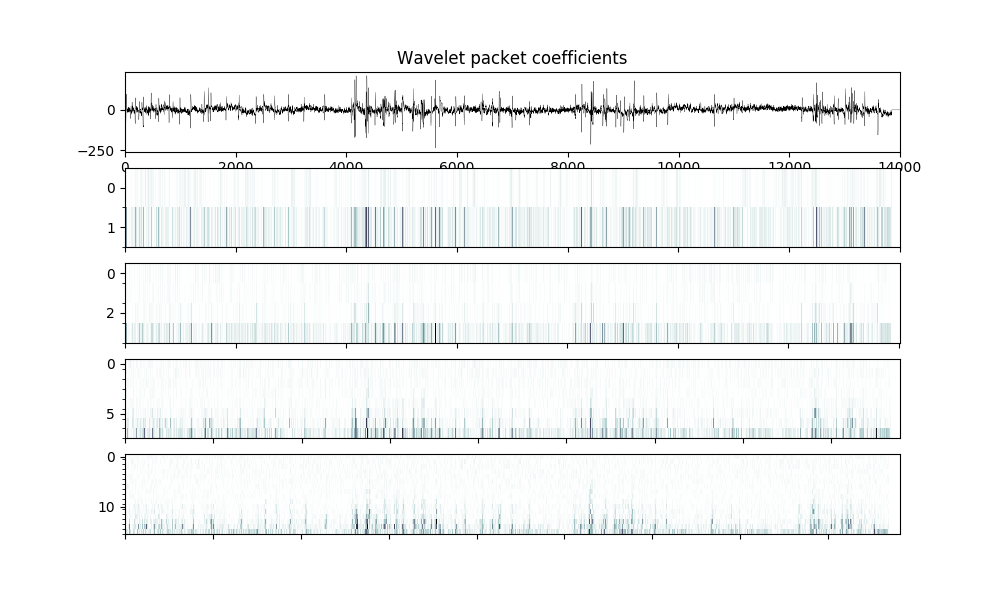

In [9]:
from pywt import WaveletPacket
import pywt.data


#ecg = pywt.data.ecg()
ecg = df['Channel 1']

wp = WaveletPacket(ecg, 'sym5', maxlevel=4)

fig = plt.figure()
plt.set_cmap('bone')
ax = fig.add_subplot(wp.maxlevel + 1, 1, 1)
ax.plot(ecg, 'k', linewidth=0.2)
ax.set_xlim(0, len(ecg) - 1)
ax.set_title("Wavelet packet coefficients")

for level in range(1, wp.maxlevel + 1):
    ax = fig.add_subplot(wp.maxlevel + 1, 1, level + 1)
    nodes = wp.get_level(level, "freq")
    nodes.reverse()
    labels = [n.path for n in nodes]
    values = -abs(np.array([n.data for n in nodes]))
    ax.imshow(values, interpolation='nearest', aspect='auto')
    ax.set_yticks(np.arange(len(labels) - 0.5, -0.5, -1), labels)
    plt.setp(ax.get_xticklabels(), visible=False)

plt.show()
fig.set_size_inches(w=10,h=6)

## Scalogram

<IPython.core.display.Javascript object>


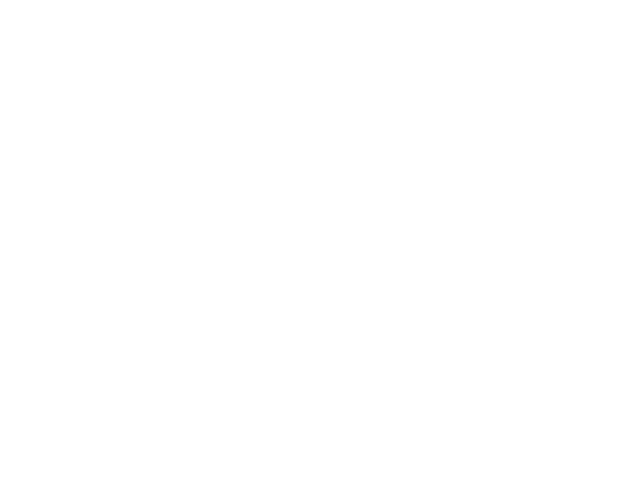

ValueError: x and y must have same first dimension, but have shapes (18000,) and (14000,)

In [10]:
#x = np.linspace(0, 1, num=512)
#data = np.sin(250 * np.pi * x**2)
x = np.linspace(0, 1, num=18000)
data = df['Channel 1']

wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# Show signal and wavelet packet coefficients
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("linchirp signal")
ax.plot(x, data, 'b')
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, 1, 0, len(values)])
ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# Show spectrogram and wavelet packet coefficients
fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")
ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()

# Filtragem

In [11]:
df_f = df.copy()
df_f['Channel 1'] = filter_signal(df['Channel 1'], low_pass=10)
df_f['Channel 1'] = filter_signal(df['Channel 1'], low_pass=10)
df_f['Channel 1'] = filter_signal(df['Channel 1'], low_pass=10)

<IPython.core.display.Javascript object>


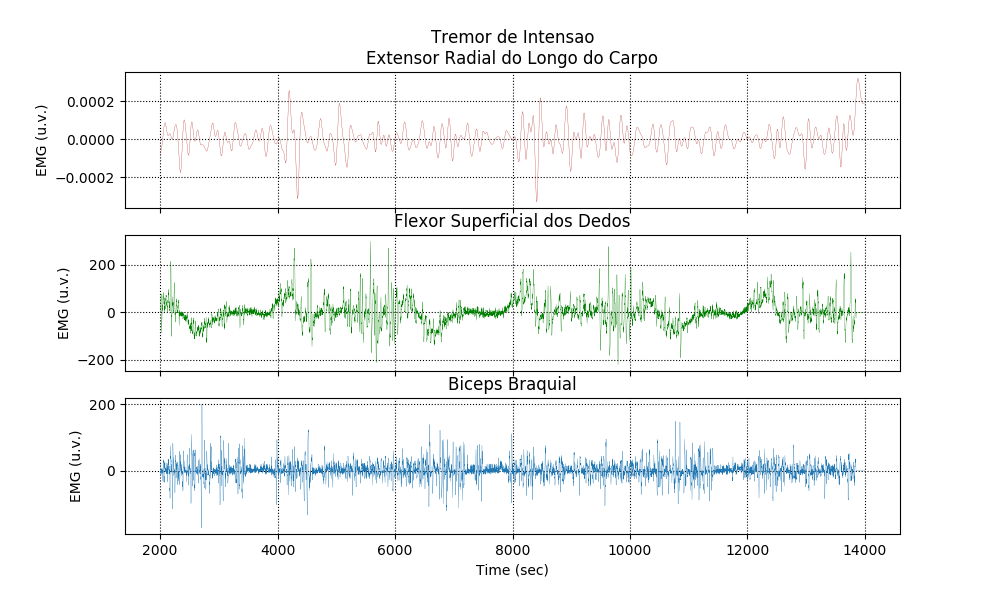

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(df_f['Channel 1'][2000:], linewidth=0.2, color = '#B22222')
ax1.set_title('Tremor de Intensao'+'\nExtensor Radial do Longo do Carpo')
ax1.set_ylabel('EMG (u.v.)')
ax1.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax2.plot(df_f['Channel 2'][2000:], linewidth=0.2, color = '#008000')
ax2.set_title('\nFlexor Superficial dos Dedos')
ax2.set_ylabel('EMG (u.v.)')
ax2.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax3.plot(df_f['Channel 3'][2000:], linewidth=0.2)
ax3.set_title('\nBiceps Braquial')
ax3.set_ylabel('EMG (u.v.)')
ax3.set_xlabel('Time (sec)')
ax3.grid()
plt.rc('grid', linestyle="dotted", color='black')
            
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.set_size_inches(w=10,h=6)

In [13]:
cA, cD = pywt.dwt(df_f['Channel 1'][2000:], 'db1')

<IPython.core.display.Javascript object>


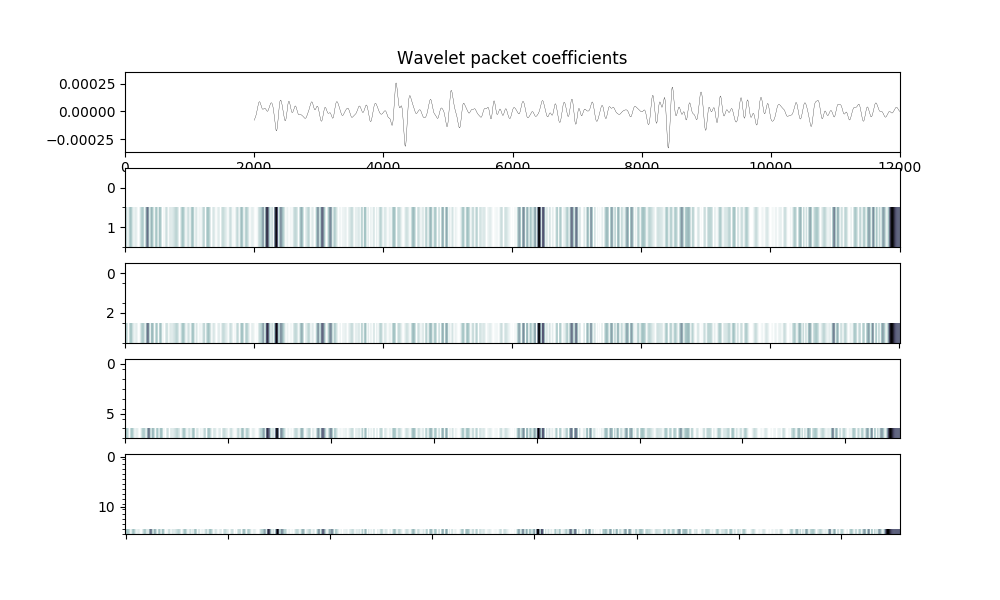

In [14]:
ecg = df_f['Channel 1'][2000:]

wp = WaveletPacket(ecg, 'sym5', maxlevel=4)

fig = plt.figure()
plt.set_cmap('bone')
ax = fig.add_subplot(wp.maxlevel + 1, 1, 1)
ax.plot(ecg, 'k', linewidth=0.2)
ax.set_xlim(0, len(ecg) - 1)
ax.set_title("Wavelet packet coefficients")

for level in range(1, wp.maxlevel + 1):
    ax = fig.add_subplot(wp.maxlevel + 1, 1, level + 1)
    nodes = wp.get_level(level, "freq")
    nodes.reverse()
    labels = [n.path for n in nodes]
    values = -abs(np.array([n.data for n in nodes]))
    ax.imshow(values, interpolation='nearest', aspect='auto')
    ax.set_yticks(np.arange(len(labels) - 0.5, -0.5, -1), labels)
    plt.setp(ax.get_xticklabels(), visible=False)

plt.show()
fig.set_size_inches(w=10,h=6)

In [15]:
def rms(a, window_size):
    def subrms(a, window_size):
        a2 = np.power(a,2)
        window = np.ones(window_size)/float(window_size)
        return np.sqrt(np.convolve(a2, window, 'valid'))

    for i in range(a.shape[1]):
        if i == 0:
            Xc = subrms(a[:, i], window_size)
        else:
            Xcp = subrms(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)

In [16]:
dfa = df.as_matrix(columns=df.columns[1:])
rms = rms(dfa,50)

<IPython.core.display.Javascript object>


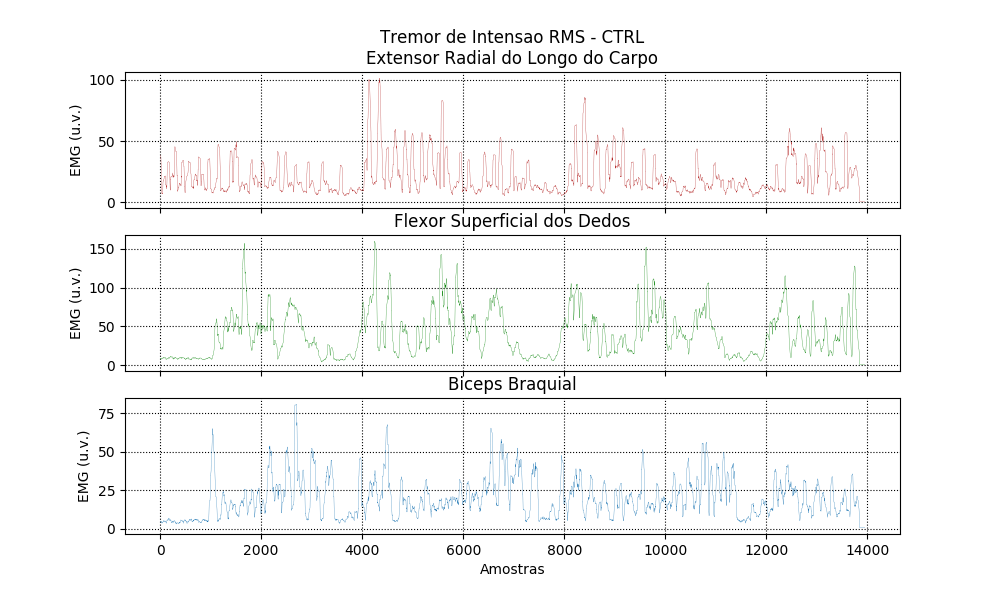

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(rms[:, [0]], linewidth=0.2, color = '#B22222')
ax1.set_title('Tremor de Intensao RMS - CTRL'+'\nExtensor Radial do Longo do Carpo')
ax1.set_ylabel('EMG (u.v.)')
ax1.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax2.plot(rms[:, [1]], linewidth=0.2, color = '#008000')
ax2.set_title('\nFlexor Superficial dos Dedos')
ax2.set_ylabel('EMG (u.v.)')
ax2.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax3.plot(rms[:, [2]], linewidth=0.2)
ax3.set_title('\nBiceps Braquial')
ax3.set_ylabel('EMG (u.v.)')
ax3.set_xlabel('Amostras')
ax3.grid()
plt.rc('grid', linestyle="dotted", color='black')
            
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.set_size_inches(w=10,h=6)
f.savefig('./DB_PROTOCOLO/edf/graficos_gerados/'+'RMS - CTRL')

In [18]:
np.ma.median(rms[:, [0]])

16.286463502138972

In [19]:
np.min((rms[:, [0]]))

0.63417721518985337

In [20]:
def f_var(a, window_size):
    def subf(a, window_size):
        Z = np.array([])
        for i in range(len(a)-window_size):
            Z = np.append(Z,np.var(a[i:window_size+i]))
        return Z
            
    for i in range(a.shape[1]):
        if i == 0:
            Xc = subf(a[:, i], window_size)
        else:
            Xcp = subf(a[:, i], window_size)
            Xc = np.vstack((Xc,Xcp))
    return np.transpose(Xc)

In [21]:
dfa = df.as_matrix(columns=df.columns[1:])
var = f_var(dfa,50)

<IPython.core.display.Javascript object>


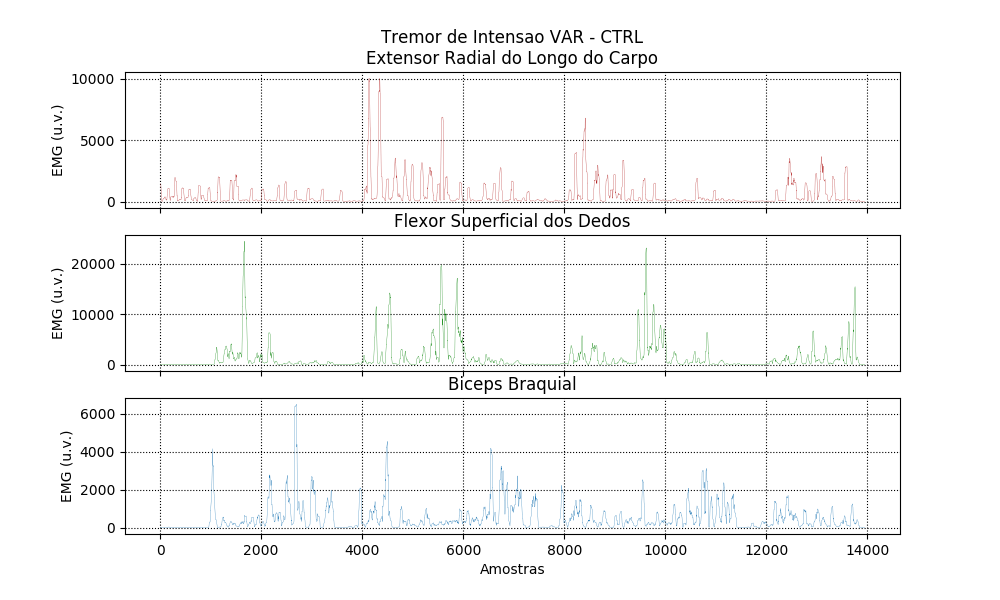

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(var[:, [0]], linewidth=0.2, color = '#B22222')
ax1.set_title('Tremor de Intensao VAR - CTRL'+'\nExtensor Radial do Longo do Carpo')
ax1.set_ylabel('EMG (u.v.)')
ax1.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax2.plot(var[:, [1]], linewidth=0.2, color = '#008000')
ax2.set_title('\nFlexor Superficial dos Dedos')
ax2.set_ylabel('EMG (u.v.)')
ax2.grid()
plt.rc('grid', linestyle="dotted", color='black')

ax3.plot(var[:, [2]], linewidth=0.2)
ax3.set_title('\nBiceps Braquial')
ax3.set_ylabel('EMG (u.v.)')
ax3.set_xlabel('Amostras')
ax3.grid()
plt.rc('grid', linestyle="dotted", color='black')
            
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
f.set_size_inches(w=10,h=6)
f.savefig('./DB_PROTOCOLO/edf/graficos_gerados/'+'VAR - CTRL')

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from detect_peaks import detect_peaks

<IPython.core.display.Javascript object>


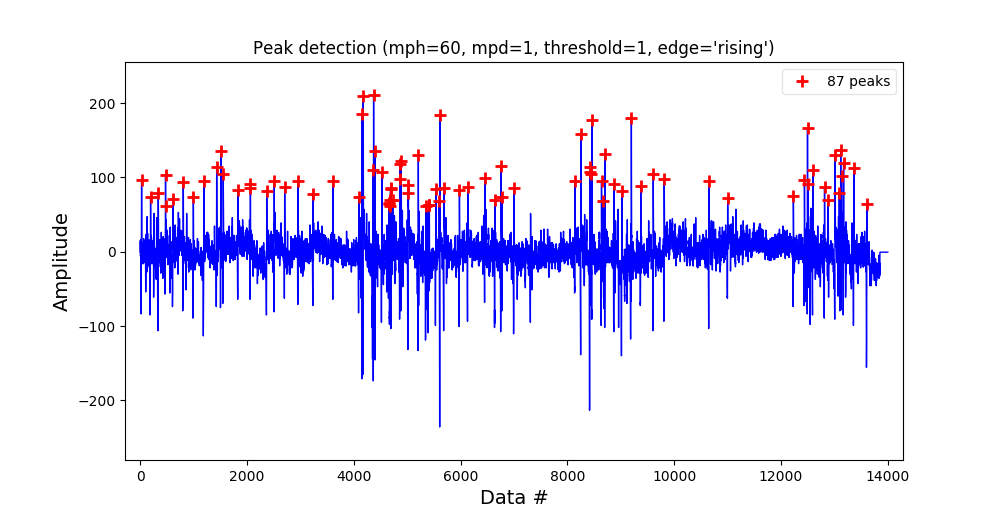

array([   24,   192,   336,   472,   475,   611,   804,   993,  1189,
        1430,  1510,  1553,  1832,  2060,  2062,  2368,  2508,  2704,
        2956,  3236,  3610,  4093,  4153,  4174,  4355,  4369,  4396,
        4523,  4656,  4658,  4673,  4679,  4686,  4698,  4728,  4864,
        4866,  4887,  5016,  5020,  5207,  5352,  5400,  5411,  5413,
        5534,  5598,  5612,  5688,  5977,  6133,  6453,  6641,  6758,
        6777,  7000,  8141,  8254,  8419,  8428,  8438,  8462,  8638,
        8668,  8705,  8873,  9020,  9197,  9373,  9607,  9812, 10651,
       11001, 12231, 12439, 12496, 12511, 12595, 12815, 12883, 13013,
       13091, 13118, 13134, 13172, 13364, 13608])

In [24]:
detect_peaks(df['Channel 1'], mph=60, mpd=1, threshold=1, valley=False, show=True)
